In [64]:
import matplotlib.patches as patches
import scipy.spatial.distance
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
import random as rand

from glob import glob
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import joblib

import PIL
import cv2

In [2]:
boat_images, nonboat_images = [], []
for path in glob("../svm_project_2022/shipsnet/*"):
    img = np.asarray(PIL.Image.open(path))
    if int(os.path.basename(path)[0]) == 1:
        boat_images.append(img)
    else:
        nonboat_images.append(img)
boat_images, nonboat_images = np.asarray(boat_images), np.asarray(nonboat_images)
total_boats, total_nonboats = boat_images.shape[0], nonboat_images.shape[0]
print("Boat images shape: ", boat_images.shape)
print("Nonboat images shape: ", nonboat_images.shape)

Boat images shape:  (1000, 80, 80, 3)
Nonboat images shape:  (3000, 80, 80, 3)


In [3]:
def extract_features(img, model = "yuv"):
    if model == "hsv": 
        ABC_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif model == "hls":
        ABC_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    else:
        ABC_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    hogA, hogA_img = hog(ABC_img[:, :, 0], 
                         orientations = 11, 
                         pixels_per_cell = (16,16), 
                         cells_per_block = (2,2), 
                         transform_sqrt = True, 
                         visualize = True, 
                         feature_vector = False)
    hogB, hogB_img = hog(ABC_img[:, :, 1],
                         orientations = 11,
                         pixels_per_cell = (16,16),
                         cells_per_block = (2,2),
                         transform_sqrt = True, 
                         visualize = True,
                         feature_vector = False)
    hogC, hogC_img = hog(ABC_img[:, :, 2],
                         orientations = 11,
                         pixels_per_cell = (16,16),
                         cells_per_block = (2,2),
                         transform_sqrt = True, 
                         visualize = True,
                         feature_vector = False)
    y_end = img.shape[1] // 16 - 1
    x_end = img.shape[0] // 16 - 1
    x_start, y_start = 0, 0
    hogA = hogA[y_start: y_end, x_start: x_end].ravel()
    hogB = hogB[y_start: y_end, x_start: x_end].ravel()
    hogC = hogC[y_start: y_end, x_start: x_end].ravel()
    hog_features = np.hstack((hogA, hogB, hogC))
    
    return hog_features

In [60]:
boat_features, nonboat_features = [], []
for i in range(len(boat_images)):
    boat_features.append(extract_features(boat_images[i], "yuv"))

In [61]:
for i in range(len(nonboat_images)):
    nonboat_features.append(extract_features(nonboat_images[i], "yuv"))

In [62]:
boat_features = np.asarray(boat_features)
print("Boat features shape: ", boat_features.shape)
nonboat_features = np.asarray(nonboat_features)
print("Nonboat features shape: ", nonboat_features.shape)

Boat features shape:  (1000, 2112)
Nonboat features shape:  (3000, 2112)


In [42]:
unscaled_x = np.vstack((boat_features, nonboat_features)).astype(np.float64)
scaler = StandardScaler().fit(unscaled_x)
x = scaler.transform(unscaled_x)
y = np.hstack((np.ones(total_boats), np.zeros(total_nonboats)))

svc = LinearSVC()
svc.fit(x, y)

# Accuracy test:

In [44]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
                                                    random_state = rand.randint(1, 100))
# svc.fit(x_train, y_train)
# accuracy = svc.score(x_test, y_test)

# print("Accuracy: ", np.round(accuracy, 4))

Accuracy:  0.9625


In [59]:
f1 = extract_features(nonboat_images[rand.randint(0, total_nonboats)])
f2 = extract_features(boat_images[rand.randint(0, total_boats)])
f3 = extract_features(boat_images[rand.randint(0, total_boats)])
f4 = extract_features(nonboat_images[rand.randint(0, total_nonboats)])

f = scaler.transform([f1, f2, f3, f4])
print("Small test: ")
print(svc.predict(f))

Small test: 
[0. 1. 1. 0.]


In [29]:
# print("Saving model: ")
# joblib.dump(svc, 'svc_yuv.pkl')
# joblib.dump(scaler, 'scaler_yuv.pkl')

Saving model: 


['scaler_hsv.pkl']

In [10]:
# print("Loading model... ")
# svc = joblib.load('svc_yuv.pkl')
# scaler = joblib.load('scaler_yuv.pkl')
# print("Model loaded")

Loading model: 


In [11]:
f1 = extract_features(nonboat_images[rand.randint(0, total_nonboats)])
f2 = extract_features(boat_images[rand.randint(0, total_boats)])
f3 = extract_features(boat_images[rand.randint(0, total_boats)])
f4 = extract_features(nonboat_images[rand.randint(0, total_nonboats)])

f = scaler.transform([f1, f2, f3, f4])
print("Small test for loaded model: ")
print(svc.predict(f))

Small test for loaded model: 
[0. 1. 1. 0.]


In [12]:
def slide_extract(image,windowSize=(80,80), step=10):
    if model == "hsv": 
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif model == "hls":
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    else:
        img = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    coords, features = [], []
    hIm,wIm = image.shape[:2] 
    for w1, w2 in zip(range(0, wIm-windowSize[0], step),range(windowSize[0], wIm, step)):
        for h1, h2 in zip(range(0, hIm-windowSize[1], step),range(windowSize[1], hIm, step)):
            window = img[h1:h2, w1:w2]
            features_of_window = extract_features(window, "yuv")
            coords.append((w1, w2, h1, h2))
            features.append(features_of_window)
    return (coords, np.asarray(features))

In [13]:
# example_image = np.asarray(PIL.Image.open("../svm_project_2022/scenes/lb_2.png"))
# coords,features = slide_extract(example_image)

# coords[:5]

In [14]:
# features.shape

In [15]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():
    def __init__(self, image):
        self.mask = np.zeros(image.shape[:2])
    def increase_value(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2, w1:w2] = self.mask[h1:h2, w1:w2] + 30
    def decrease_value(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2, w1:w2] = self.mask[h1:h2, w1:w2] - 3
    def construct(self):
        scaler = MinMaxScaler()
        self.mask = scaler.fit_transform(self.mask)
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        self.mask = cv2.inRange(self.mask, 170, 255)
        
        return self.mask

In [16]:
def detect(image):
    coords, features = slide_extract(image)
    if model == "hsv": 
        scaler = joblib.load('scaler_hsv.pkl')
        svc = joblib.load('svc_hsv.pkl')
    elif model == "hls":
        scaler = joblib.load('scaler_hls.pkl')
        svc = joblib.load('svc_hls.pkl')
    else:
        scaler = joblib.load('scaler_yuv.pkl')
        svc = joblib.load('svc_yuv.pkl')
    features = scaler.transform(features)
    heatmap = Heatmap(image)
    for i in range(len(features)):
        # window = image[coords[i][2]:coords[i][3], coords[i][0]:coords[i][1]]
        # plt.imshow(window)
        # plt.show()
        decision = svc.predict([features[i]])
        # print(decision[0])
        if decision[0] == 1:
            heatmap.increase_value(coords[i])
        # else:
            # heatmap.decrease_value(coords[i])
    mask = heatmap.construct()
    plt.imshow(mask)
    plt.show()
    contour, _ = cv2.findContours(mask, 1, 2)[:2]
    for c in contour:
        if (cv2.contourArea(c) < 15 * 15) or (cv2.contourArea(c) > 120 * 120):
            continue
        (x, y, w, h) = cv2.boundingRect(c)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (255), 2)
    return image

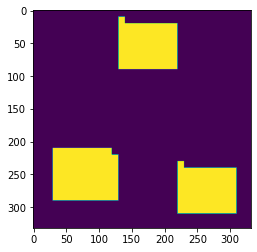

Time taken: 12.88


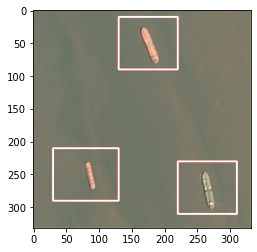

In [70]:
t_start = time.time()
detected = detect(np.asarray(PIL.Image.open("../svm_project_2022/scenes/scale.png")))
cv2.imwrite("../svm_project_2022/saved.png", cv2.cvtColor(detected, cv2.COLOR_RGB2BGR))
print("Time taken:", np.round(time.time() - t_start, 2))
plt.imshow(detected)
plt.show()